# Clasificación de Estilos Arquitectónicos con Redes Neuronales

## Bibliotecas

In [2]:
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Para graficar los resultados
import os  # Para operaciones relacionadas con el sistema de archivos
import shutil  # Para copiar y mover archivos o directorios
import zipfile  # Para trabajar con archivos ZIP
import kagglehub  # Para descargar conjuntos de datos desde Kaggle

# Importar librerías necesarias para deep learning
import tensorflow as tf  # Librería TensorFlow para aprendizaje profundo
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Para preprocesamiento y aumento de imágenes
from tensorflow.keras.applications import VGG16  # Modelo preentrenado VGG16 para aprendizaje por transferencia
from tensorflow.keras.models import Sequential  # API secuencial para definir modelos
from tensorflow.keras.layers import Flatten, Dense, Dropout  # Capas para construir el modelo
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Para cargar imágenes y convertirlas a matrices

# Importar herramientas de sklearn para división de datos y manejo de clases desequilibradas
from sklearn.model_selection import train_test_split  # Para dividir los datos en entrenamiento, validación y prueba
from sklearn.utils.class_weight import compute_class_weight  # Para manejar desequilibrios en las clases calculando pesos de clase

## Descargamos el dataset y creamos las clases de entrenamiento


In [3]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Descargamos el dataset
kagglehub.dataset_download('dumitrux/architectural-styles-dataset')

# Directorio del conjunto de datos original
dataset_dir = '/root/.cache/kagglehub/datasets/dumitrux/architectural-styles-dataset/versions/3/architectural-styles-dataset'
categories = [
    'American Foursquare architecture', 'Ancient Egyptian architecture',
    'Baroque architecture', 'Byzantine architecture', 'Colonial architecture',
    'Deconstructivism', 'Gothic architecture', 'Novelty architecture',
    'Postmodern architecture', 'Russian Revival architecture'
]

# Crear el directorio 'data' y las particiones de datos
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# Tamaño objetivo (350 imágenes por clase)
target_size = 350

# Dividir los datos y mover las imágenes a los directorios correspondientes
for category in categories:
    category_path = os.path.join(dataset_dir, category)
    images = os.listdir(category_path)

    # Limitar a un número objetivo de imágenes por categoría (350 imágenes o todo si es menor)
    if len(images) > target_size:
        selected_images = random.sample(images, target_size)
    else:
        selected_images = images  # Usar todas las imágenes si son menos que el tamaño objetivo

    # División de los datos en Train/Validation/Test
    train_images, temp_images = train_test_split(selected_images, test_size=0.15, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.15, random_state=42)

    for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        split_folder = os.path.join(data_dir, split, category)
        os.makedirs(split_folder, exist_ok=True)
        for image in split_images:
            shutil.copy(os.path.join(category_path, image), os.path.join(split_folder, image))

print("Los datos han sido divididos y redimensionados correctamente.")

100%|██████████| 1.56G/1.56G [01:11<00:00, 23.4MB/s]

Extracting files...


Los datos han sido divididos y redimensionados correctamente.


### Análisis Exploratorio de Datos

El conjunto de datos utilizado para este proyecto proviene de Kagglehub, específicamente de un dataset titulado “architectural-styles-dataset”. Este conjunto de datos está compuesto por imágenes de diferentes estilos arquitectónicos. En este caso, seleccionamos 10 categorías de estilos arquitectónicos para realizar la clasificación mediante redes neuronales. Las imágenes fueron obtenidas a partir de Google Images y de un conjunto de datos previamente utilizado en un artículo de investigación.

Estructura del Dataset

El dataset está organizado de la siguiente manera:
* architecture-style-dataset: Contiene imágenes de 10 estilos arquitectónicos.
* Cada estilo arquitectónico tiene un directorio que contiene imágenes correspondientes a ese estilo.
* Número total de imágenes: 3,739
* Cada imagen está etiquetada con el estilo arquitectónico al que pertenece.

Categorías de Estilos Arquitectónicos Seleccionadas

Para este proyecto, se seleccionaron las siguientes 10 categorías de estilos arquitectónicos:  
1. Ancient Egyptian architecture (406 imágenes)  
2. American Foursquare architecture (362 imágenes)  
3. Russian Revival architecture (352 imágenes)  
4. Postmodern architecture (322 imágenes)  
5. Novelty architecture (382 imágenes)  
6. Gothic architecture (331 imágenes)  
7. Deconstructivism (335 imágenes)  
8. Colonial architecture (480 imágenes)  
9. Byzantine architecture (313 imágenes)  
10. Baroque architecture (456 imágenes)

## Distribución de Clases en Train


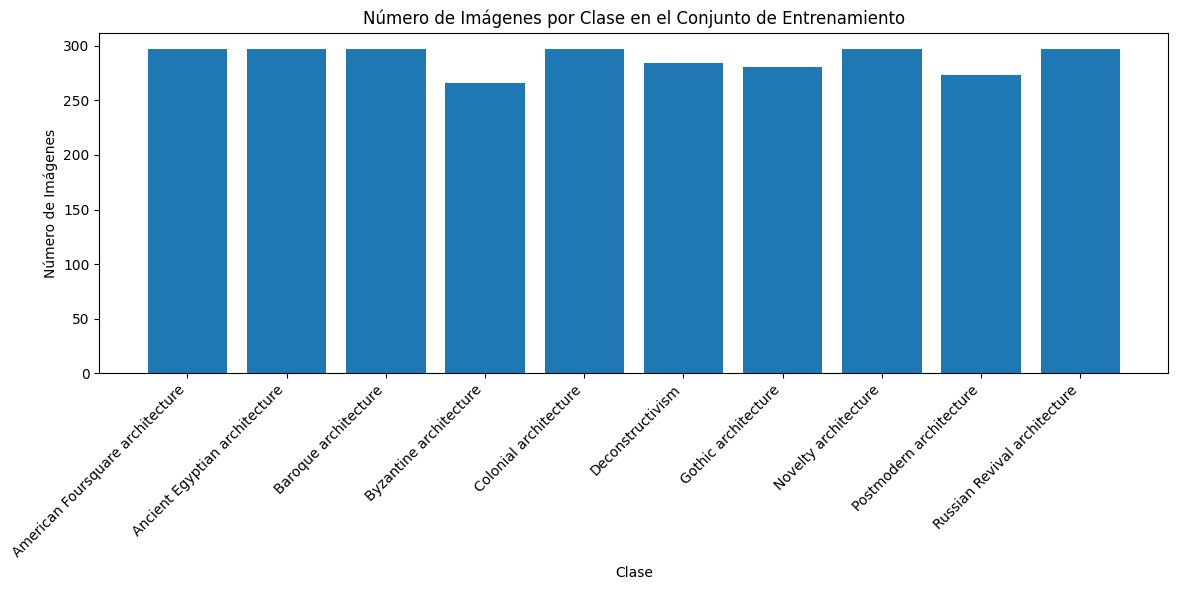

In [4]:
# Ruta al directorio del conjunto de entrenamiento
train_dir = os.path.join('data', 'train')

# Contar el número de imágenes por clase
class_counts = {}  # Diccionario para almacenar las cantidades de imágenes por clase
for class_name in os.listdir(train_dir):  # Iterar sobre cada clase en el directorio de entrenamiento
    class_path = os.path.join(train_dir, class_name)  # Construir la ruta completa de la clase
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))  # Contar imágenes en la clase y almacenar en el diccionario

# Ordenar las clases en orden alfabético
class_counts = dict(sorted(class_counts.items()))

# Graficar la cantidad de imágenes por clase
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())  # Crear gráfica de barras
plt.title('Número de Imágenes por Clase en el Conjunto de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Entrenar modelo

In [5]:
# Directorios para el conjunto de datos
train_dir, val_dir, test_dir = 'data/train', 'data/val', 'data/test'  # Ruta a los datos de entrenamiento, validación y prueba

# Aumento de datos y reescalado para las imágenes de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalizar los valores de los píxeles al rango [0, 1]
    rotation_range=15,  # Rotar las imágenes aleatoriamente hasta 15 grados
    width_shift_range=0.1,  # Desplazar las imágenes aleatoriamente horizontalmente hasta un 10%
    height_shift_range=0.1,  # Desplazar las imágenes aleatoriamente verticalmente hasta un 10%
    horizontal_flip=True  # Voltear las imágenes aleatoriamente en horizontal
)

# Solo reescalar las imágenes de validación y prueba (sin aumento de datos)
val_test_datagen = ImageDataGenerator(rescale=1./255)  # Solo reescalado para las imágenes de validación y prueba

# Crear generadores de datos para los conjuntos de entrenamiento, validación y prueba
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Ruta a los datos de entrenamiento
    target_size=(224, 224),  # Redimensionar las imágenes a 224x224 (tamaño de entrada requerido para VGG16)
    batch_size=32,  # Número de imágenes por lote
    class_mode='categorical'  # Clasificación multiclase (salida de etiquetas codificadas en one-hot)
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,  # Ruta a los datos de validación
    target_size=(224, 224),  # Redimensionar las imágenes a 224x224
    batch_size=32,  # Número de imágenes por lote
    class_mode='categorical'  # Clasificación multiclase
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,  # Ruta a los datos de prueba
    target_size=(224, 224),  # Redimensionar las imágenes a 224x224
    batch_size=32,  # Número de imágenes por lote
    class_mode='categorical'  # Clasificación multiclase
)

# Calcular los pesos de las clases para manejar el desequilibrio en el conjunto de datos
class_weights = compute_class_weight(
    'balanced',  # Usar pesos balanceados basados en la distribución de clases
    classes=np.unique(train_generator.classes),  # Obtener las clases únicas del conjunto de datos de entrenamiento
    y=train_generator.classes  # Etiquetas de clase del generador de datos de entrenamiento
)

# Cargar el modelo VGG16 preentrenado sin las capas completamente conectadas (top)
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelar las capas de VGG16, para que no se actualicen durante el entrenamiento

# Construir el modelo personalizado con la base VGG16
model = Sequential([
    base_model,  # Agregar el modelo VGG16 congelado como base
    Flatten(),  # Aplanar la salida 3D del modelo VGG16 en un vector 1D
    Dense(256, activation='relu'),  # Capa completamente conectada con 256 unidades y activación ReLU
    Dropout(0.5),  # Capa de Dropout con una probabilidad del 50% para evitar el sobreajuste
    Dense(train_generator.num_classes, activation='softmax')  # Capa de salida para clasificación multiclase
])

# Compilar el modelo con el optimizador Adam y la función de pérdida de entropía cruzada categórica
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),  # Optimizar con Adam y una tasa de aprendizaje de 0.0001
              loss='categorical_crossentropy',  # Función de pérdida de entropía cruzada categórica para clasificación multiclase
              metrics=['accuracy'])  # Evaluar precisión durante el entrenamiento y la validación

# Entrenar el modelo con los datos de entrenamiento y validarlo con los datos de validación
history = model.fit(
    train_generator,  # Datos de entrenamiento
    validation_data=val_generator,  # Datos de validación
    epochs=15,  # Número de épocas de entrenamiento
    class_weight=dict(enumerate(class_weights)),  # Aplicar los pesos de clase calculados para balancear las clases
    callbacks=[  # Callbacks para detener el entrenamiento temprano y reducir la tasa de aprendizaje cuando se estabiliza la pérdida
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),  # Detener el entrenamiento temprano si la pérdida de validación no mejora
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Reducir la tasa de aprendizaje si la pérdida de validación se estabiliza
    ]
)

# Ajustar el modelo descongelando las últimas capas del modelo base
base_model.trainable = True  # Descongelar las capas de VGG16
for layer in base_model.layers[:-8]:  # Congelar todas las capas menos las últimas 8 de VGG16
    layer.trainable = False

# Volver a compilar el modelo con una tasa de aprendizaje más baja para el ajuste fino
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Tasa de aprendizaje más baja para el ajuste fino
              loss='categorical_crossentropy',  # Mismo función de pérdida
              metrics=['accuracy'])  # Mismos métricas

# Ajustar el modelo con los datos de entrenamiento
history_finetune = model.fit(
    train_generator,  # Datos de entrenamiento
    validation_data=val_generator,  # Datos de validación
    epochs=10,  # Número de épocas para el ajuste fino
    class_weight=dict(enumerate(class_weights)),  # Aplicar nuevamente los pesos de clase
    callbacks=[  # Callbacks para detener el entrenamiento temprano y reducir la tasa de aprendizaje
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=1e-6)
    ]
)

Found 2886 images belonging to 10 classes.
Found 435 images belonging to 10 classes.
Found 80 images belonging to 10 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


91/91 ━━━━━━━━━━━━━━━━━━━━ 81s 681ms/step - accuracy: 0.2670 - loss: 2.1289 - val_accuracy: 0.6276 - val_loss: 1.1350 - learning_rate: 1.0000e-04
Epoch 2/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 48s 491ms/step - accuracy: 0.5615 - loss: 1.2736 - val_accuracy: 0.6851 - val_loss: 0.9485 - learning_rate: 1.0000e-04
Epoch 3/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 50s 517ms/step - accuracy: 0.6451 - loss: 1.0617 - val_accuracy: 0.7264 - val_loss: 0.8228 - learning_rate: 1.0000e-04
Epoch 4/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 47s 491ms/step - accuracy: 0.6909 - loss: 0.9379 - val_accuracy: 0.7333 - val_loss: 0.8035 - learning_rate: 1.0000e-04
Epoch 5/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 487ms/step - accuracy: 0.7063 - loss: 0.8604 - val_accuracy: 0.7540 - val_loss: 0.7421 - learning_rate: 1.0000e-04
Epoch 6/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 83s 498ms/step - accuracy: 0.7403 - loss: 0.7945 - val_accuracy: 0.7563 - val_loss: 0.7329 - learning_rate: 1.0000e-04
Epoch 7/15
91/91 ━━━━━━━━━━━━━━━━━━━━ 81s 485ms/step - accuracy: 0.74

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,949,152 (228.69 MB)

 Trainable params: 19,404,554 (74.02 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

 Optimizer params: 38,809,110 (148.05 MB)

## Resultados

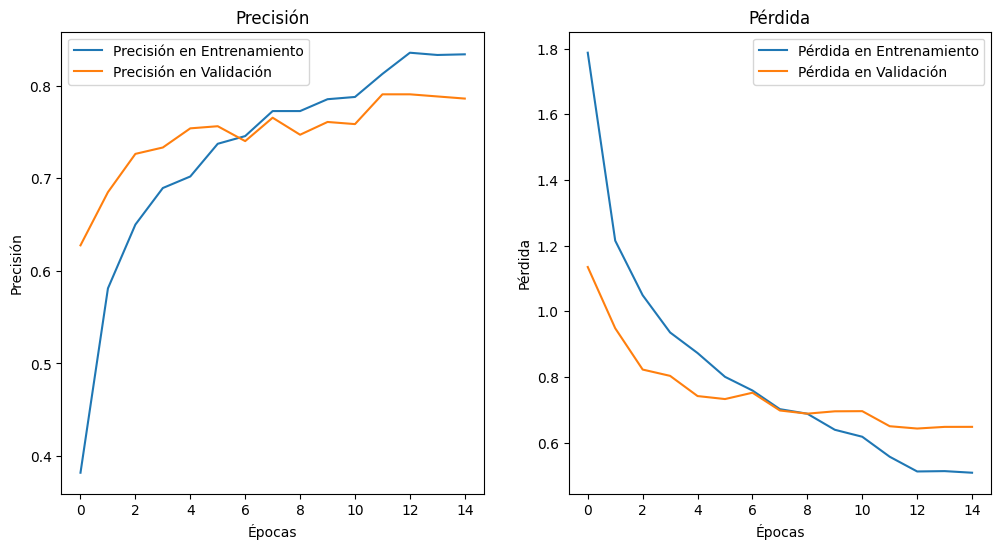

In [7]:
# Graficar la precisión y la pérdida de entrenamiento y validación para análisis
plt.figure(figsize=(12, 6))

# Graficar la precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.title('Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Graficar la pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.title('Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()

In [8]:
# Evaluar el modelo final con los datos de prueba
test_loss, test_acc = model.evaluate(test_generator)  # Evaluar el modelo con el conjunto de prueba
print(f"Precisión en prueba: {test_acc:.2f}")  # Imprimir la precisión en prueba

# Guardar el modelo entrenado en un archivo
model.save('image_classifier_model.keras')

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.7930 - loss: 0.6997
Precisión en prueba: 0.81


## Pruebas sobre el modelo

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step


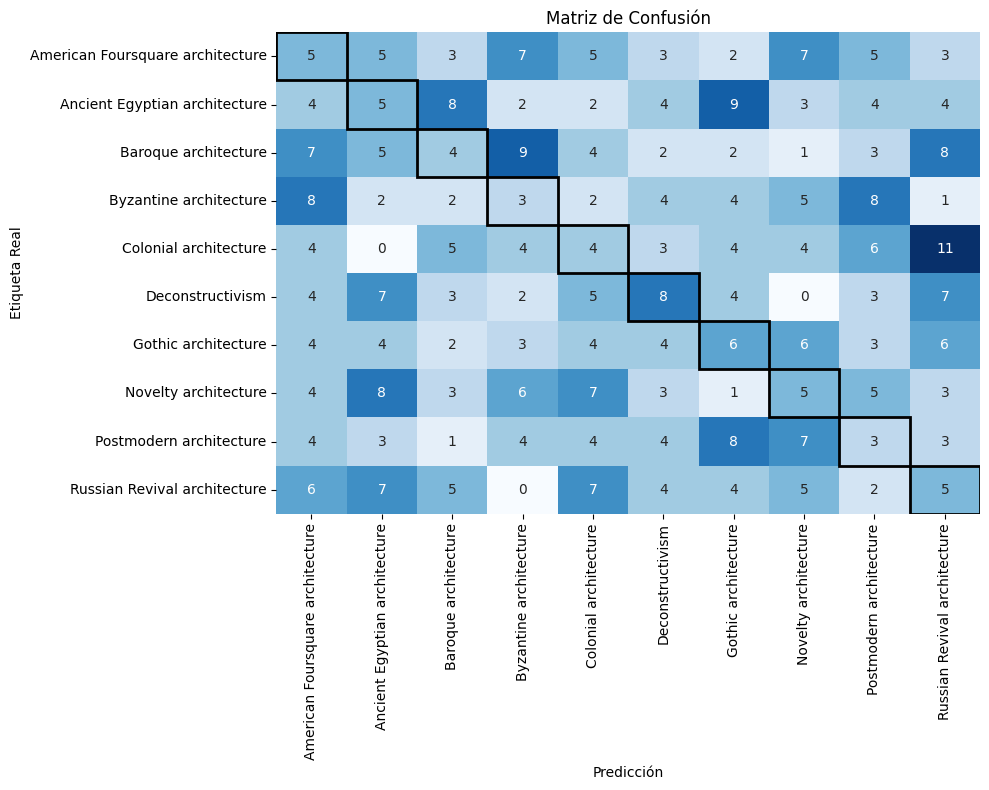

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, generator):
    # Obtener las etiquetas reales y las predicciones
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred = np.argmax(y_pred, axis=1)  # Convertir probabilidades en índices de clases predichas

    # Crear la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Crear la figura
    plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # Visualizar la matriz de confusión
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=generator.class_indices.keys(),
                yticklabels=generator.class_indices.keys(),
                cbar=False, ax=ax)

    # Marcar la diagonal con bordes negros
    for i in range(cm.shape[0]):
        ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='black', lw=2))

    # Títulos y etiquetas
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Evaluación en el conjunto de validación
evaluate_model(model, val_generator)